# Регрессия - пора творить!

Если вы дошли до этой практики и выполнили все предыдущие - вау! Аплодисменты вам!

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/leo.png" width=500/></p>



Тем не менее, не время расслабляться! На этот раз, мы не будем рассказывать вам новый материал - лишь дадим пару напутствий и пожелаем успехов и сил!

В этот раз вам предлагается разработать модель предсказания цены домов по набору данных Boston Houses Pricing. Мы его уже немного пощупали в прошлой практике, но в этой вам предстоит сделать всё самостоятельно и на полных данных!

Что надо будет сделать:
- Загрузить данные
- Посмотреть и размер, и примеры данных
- Проверить количество пропусков в данных
    - Убедиться, что пропусков в данных нет и можно строить **baseline**
- Делим данные на train и test 
    - Делаем это один раз! Все дальнейшие модификации и улучшения должны делаться на основе единственного разделения!
    - И не забудьте зафиксировать сид! Переменную `RANDOM_SEED` мы даём ниже
- Создаем baseline модель, снимаем метрики на тестовой выборке
- Производим анализ данных, готовим план по очистке и предобработке данных
- Создаем функцию очистки
- Производим очистку train и test выборок -> обучаем модель с очищенными данными
    - Снимаем метрики и так мы оцениваем влияние очистки данных на обучение
- Создаем класс предобработки данных
- Производим предобработку очищенных данных -> обучаем модель
    - Снимаем метрики и так мы оцениваем влияние предобработки данных на обучение

А дальше можете пофантазировать, почитать интернет и посмотреть, как улучшить метрики! 

**Ваша цель - достигнуть наилучших показателей!**

Вот вам пара идей по интересной организации предобработке:
- По признаку `CRIM` создать признак `is_CRIM`, который будет равен 1, если `CRIM` не равен 0 и 0, если `CRIM` равен нулю
- Сделать обучение модели [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), посмотреть, какие признаки имеют веса близкие к 0 и убрать их из обучения как незначимые
- Оставить только признаки с высокой корреляцией с целевой переменной
- Посмотреть, какие переменные коррелирцют между собой и оставить только единственные из пар коррелирующих
- Посмотреть, в каких примерах данных модель ошибается сильнее всего (отсортировать записи из теста по величине ошибки) и проанализировать, есть ли какая-то зависимость или шум
- Комбинировать разные подходы в зависимости от того, помогает это предсказаниям или нет

Ещё большим плюсом будет, если вы покажете, как влияет каждый этап предобработки на результаты обучения!

In [1]:
# Зафиксируем состояние случайных чисел
import numpy as np
import random

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Что мы ждем от вас? 

Готовый ноутбук с таким же названием, в котором будут обязательные пункты с выводами по анализу данных и анализу поведения модели, а также дополнительные пункты по вашим размышлениям и процессу улучшения модели.

Успехов вам, мы в вас верим и уверены, что вы точно справитесь!

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/cat-computer-peek-out-36960208.jpg" width=600/></p>

In [2]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import boxcox
import matplotlib
import pandas as pd
import seaborn as sns

In [3]:
df = pd.read_csv('boston.csv')
print(df.shape)
df.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [5]:
df.isnull().sum().sum()

0

In [6]:
df.duplicated().sum()

0

In [7]:
def print_metrics(model_, x_test, y_test_):
    y_pred_ = model_.predict(x_test)
    metrics = {
        'R2': r2_score(y_test_, y_pred_),
        'MSE': mean_squared_error(y_test_, y_pred_),
        'MAE': mean_absolute_error(y_test_, y_pred_)
    }

    for key, value in metrics.items():
        print(f'{key}: {value:.6f}')

In [8]:
# Деление данных на train и test
y = df['MEDV']
X = df.drop(columns='MEDV')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, shuffle=True)

In [9]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [10]:
print_metrics(model, X_test,  y_test)

R2: 0.711226
MSE: 21.517444
MAE: 3.162710


# Анализ данных

In [11]:
# Построение гистограмм для каждого признака
def plot_feature_distributions(data, num_cols=3):
    sns.set(style="whitegrid")

    features = data.columns

    num_plots = len(features)
    num_rows = (num_plots // num_cols) + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))

    for i, feature in enumerate(features):
        row = i // num_cols
        col = i % num_cols

        sns.histplot(data[feature], kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'Distribution of {feature}')

    plt.tight_layout()
    plt.show()

In [12]:
def print_boxplots(data, num_cols=3):
    sns.set(style="whitegrid")

    features = data.columns
    num_rows = -(-len(features) // num_cols)
    plt.figure(figsize=(15, 4*num_rows))
    for i, feature in enumerate(features, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.boxplot(x=data[feature])
        plt.title(f'Boxplot for {feature}')

    plt.tight_layout()
    plt.show()

In [13]:
def print_violinplots(data, num_cols=3):
    sns.set(style="whitegrid")

    features = data.columns
    num_rows = -(-len(features) // num_cols)
    plt.figure(figsize=(15, 4*num_rows))
    for i, feature in enumerate(features, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.violinplot(x=data[feature])
        plt.title(f'Violin Plot for {feature}')

    plt.tight_layout()
    plt.show()

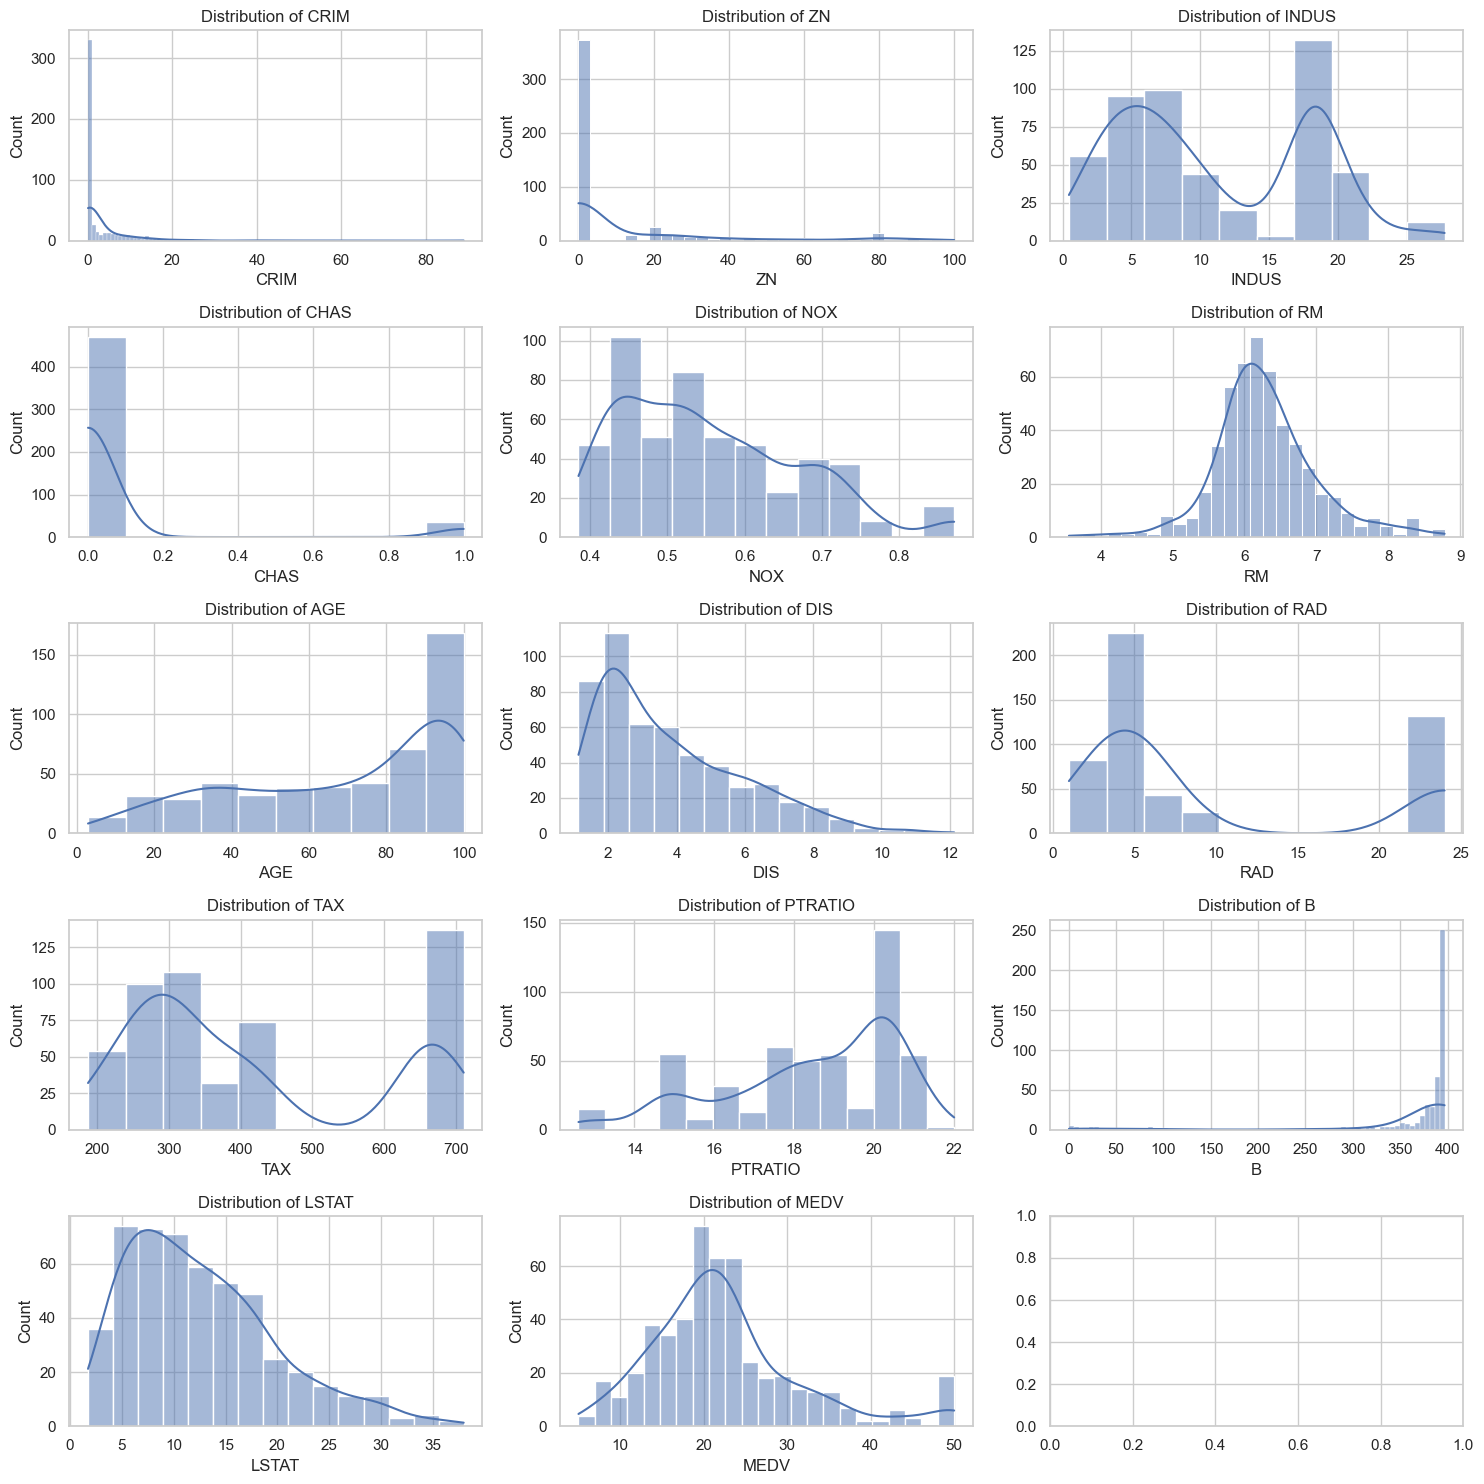

In [14]:
plot_feature_distributions(df)

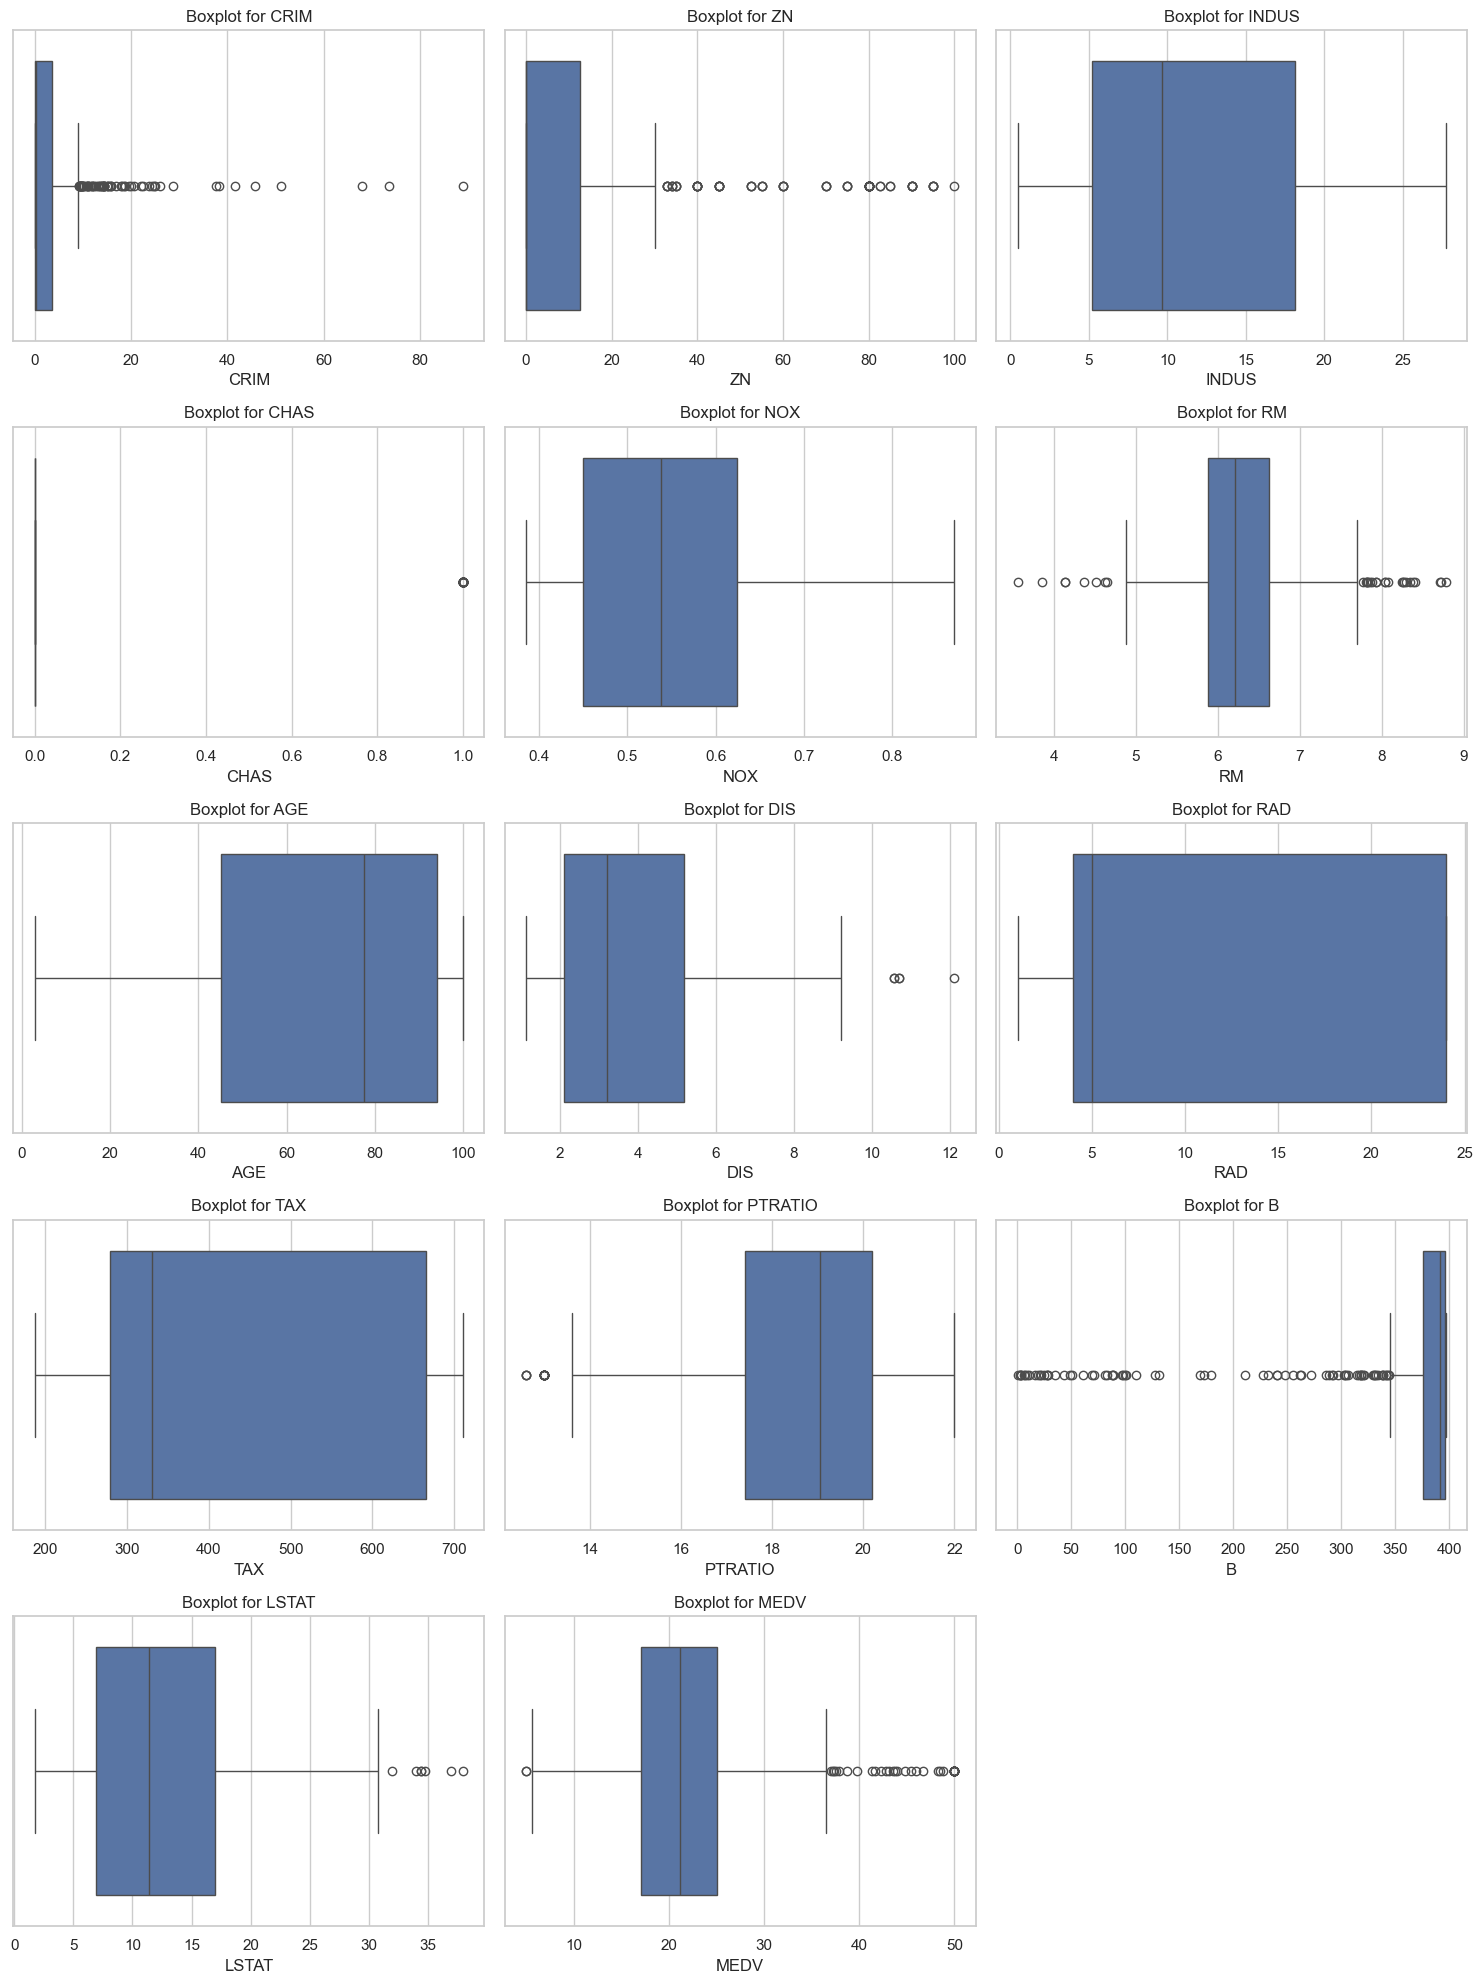

In [15]:
print_boxplots(df, num_cols= 3)

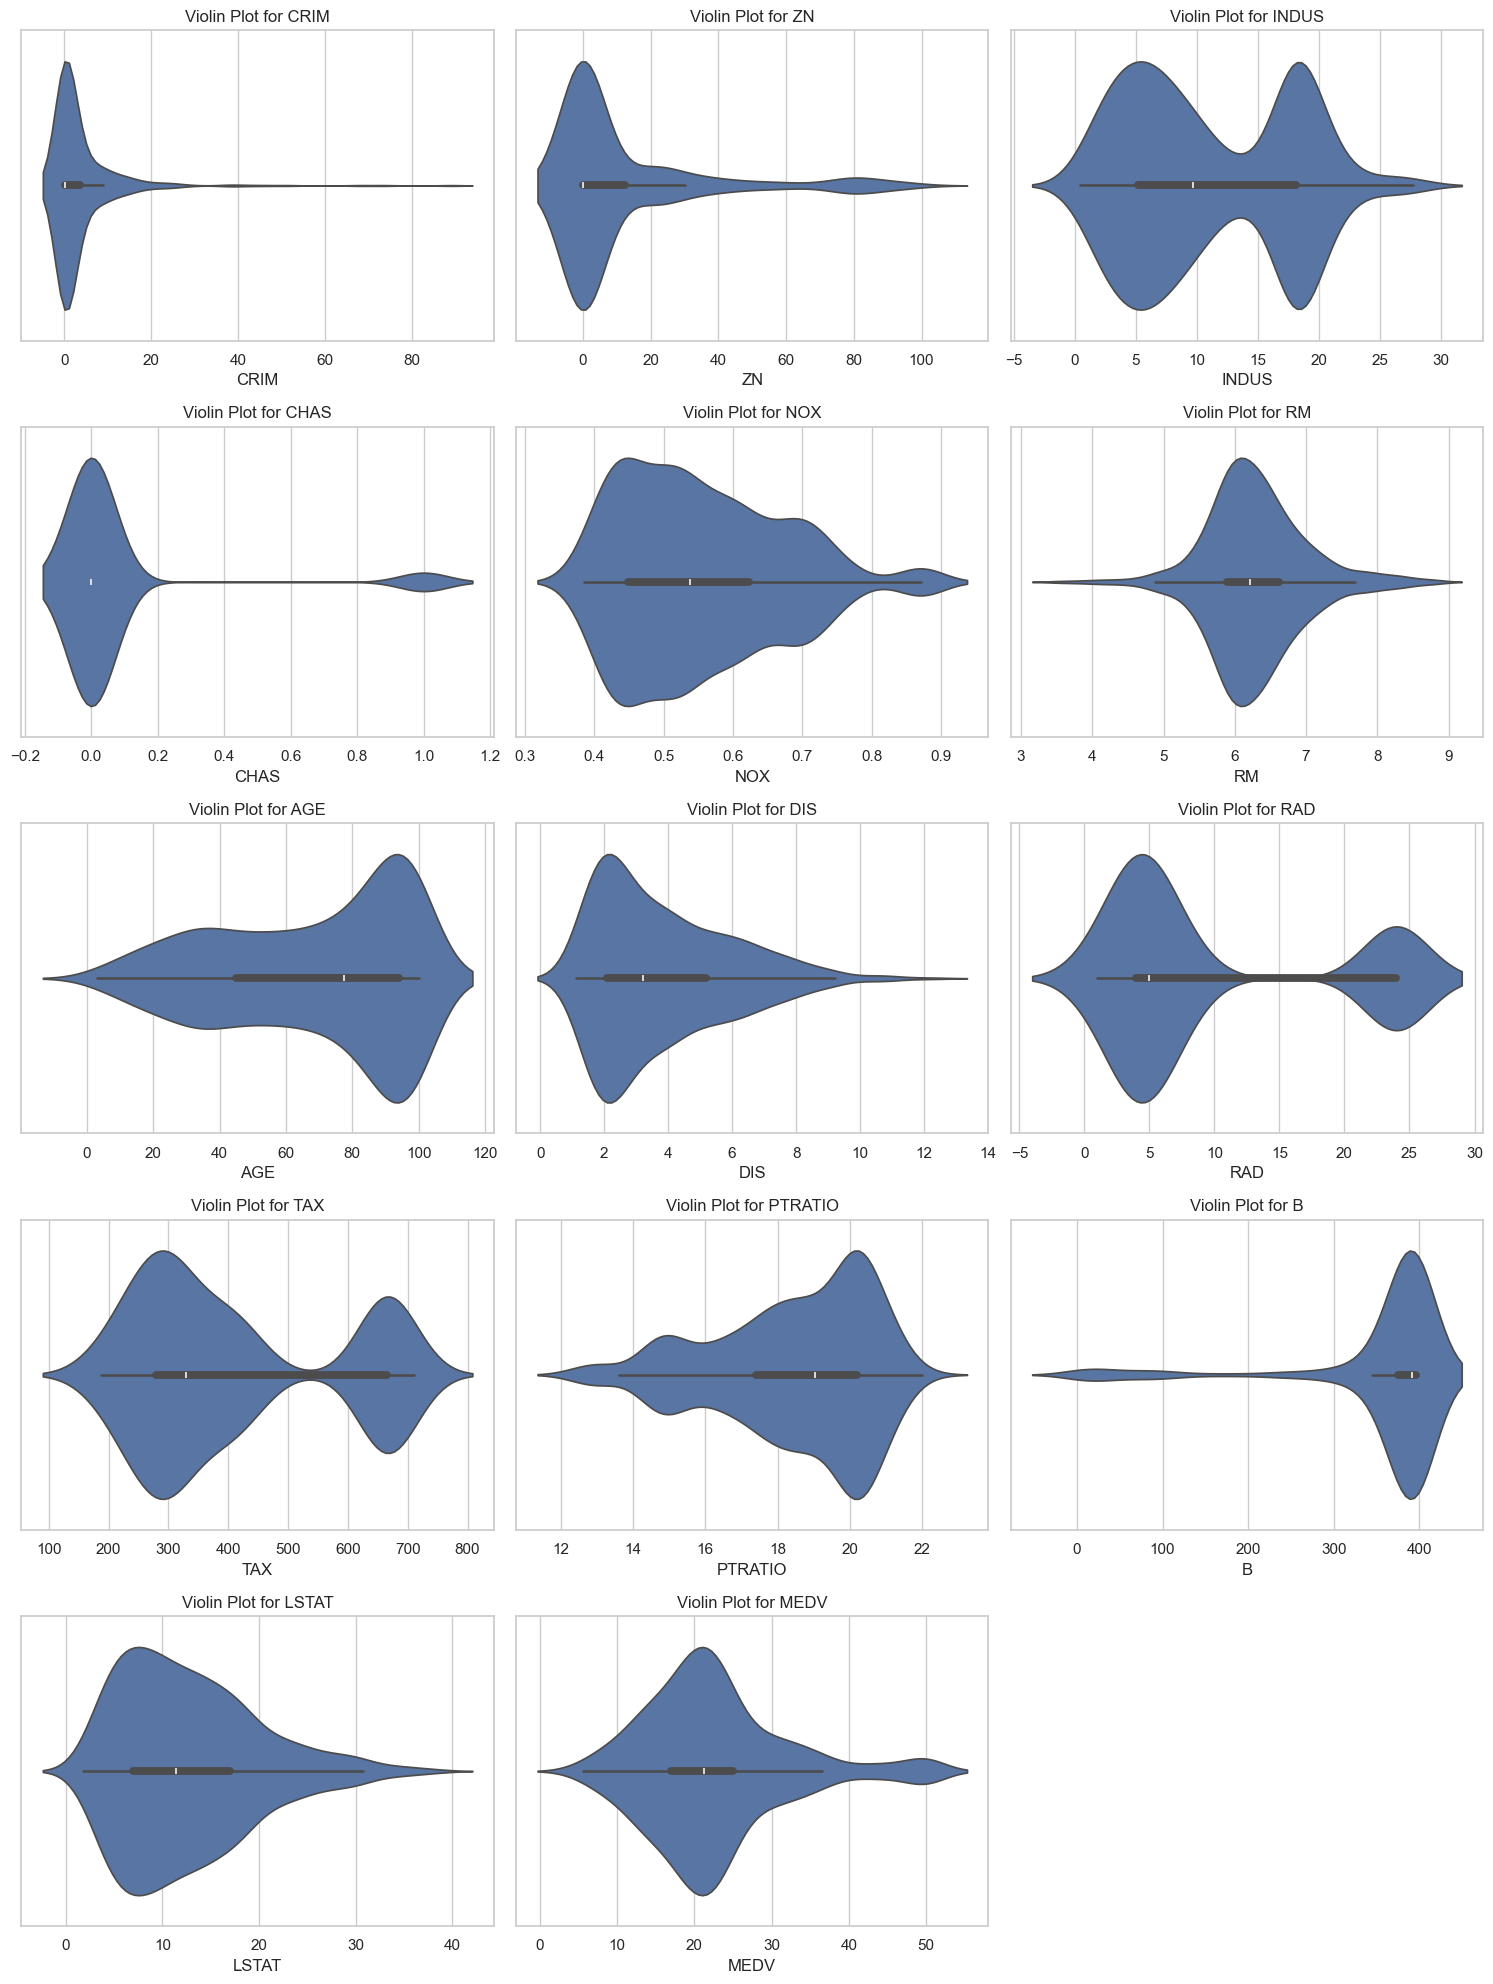

In [16]:
print_violinplots(df)

In [17]:
def print_corr_matrix(corr_martix):
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr_martix, annot=True, fmt='.2f')

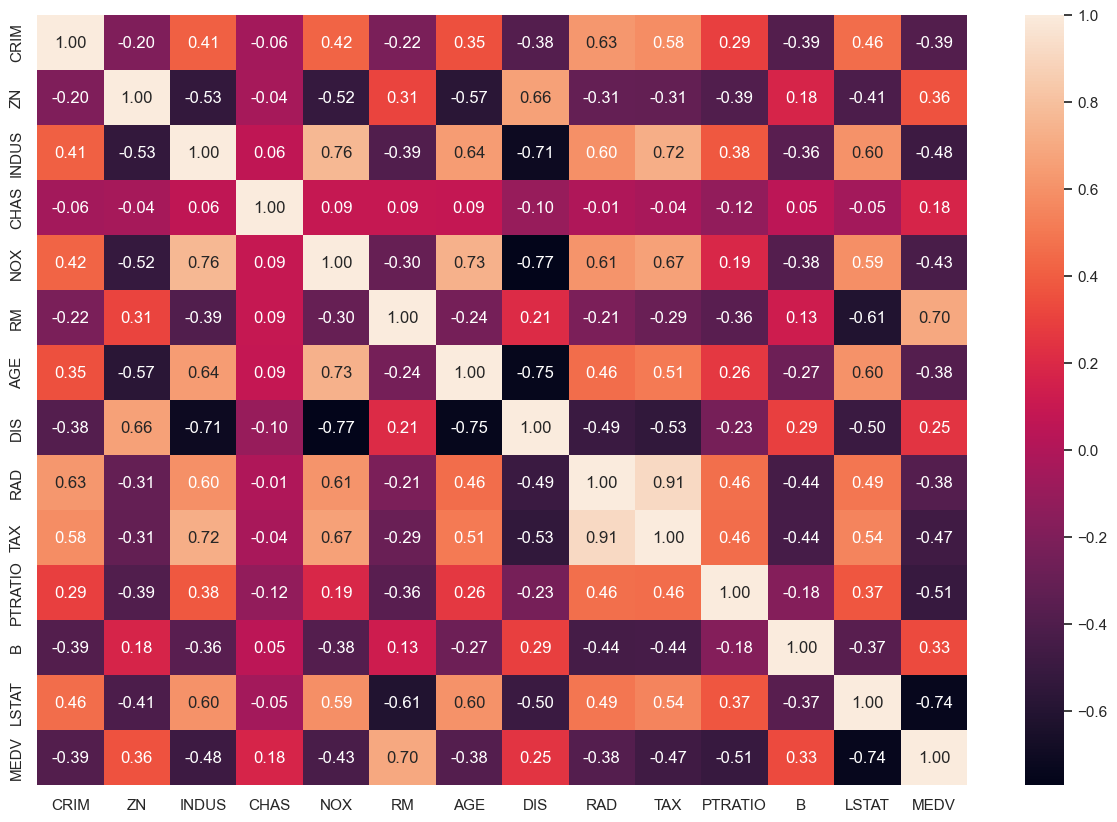

In [18]:
correlation_mtrx = df.corr()
print_corr_matrix(correlation_mtrx)

# Очистка данных

In [19]:
def get_outliers(data, columns):
    result = data.copy()
    limits = {}
    for column in columns:
        q1 = result[column].quantile(0.25)
        q3 = result[column].quantile(0.75)
        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        limits[column] = {'lower': lower_bound, 'upper': upper_bound}

    return limits

In [20]:
def clean_data(X_train, X_test, y_train, y_test, limits_dict):
    X_train_cleaned = X_train.copy()
    X_test_cleaned = X_test.copy()
    y_train_cleaned = y_train.copy()
    y_test_cleaned = y_test.copy()

    for column, limits in limits_dict.items():
        lower_bound = limits['lower']
        upper_bound = limits['upper']

        if column in X_train_cleaned.columns:
            X_train_cleaned = X_train_cleaned[(X_train_cleaned[column] >= lower_bound) & (X_train_cleaned[column] <= upper_bound)]
            X_test_cleaned = X_test_cleaned[(X_test_cleaned[column] >= lower_bound) & (X_test_cleaned[column] <= upper_bound)]

    y_lower_bound = limits_dict['MEDV']['lower']
    y_upper_bound = limits_dict['MEDV']['upper']

    common_index_train = y_train_cleaned.index.intersection(X_train_cleaned.index)
    y_train_cleaned = y_train_cleaned.loc[common_index_train]
    X_train_cleaned = X_train_cleaned.loc[common_index_train]

    common_index_test = y_test_cleaned.index.intersection(X_test_cleaned.index)
    y_test_cleaned = y_test_cleaned.loc[common_index_test]
    X_test_cleaned = X_test_cleaned.loc[common_index_test]

    y_train_cleaned = y_train_cleaned[(y_train_cleaned >= y_lower_bound) & (y_train_cleaned <= y_upper_bound)]
    common_index_train = y_train_cleaned.index.intersection(X_train_cleaned.index)
    X_train_cleaned = X_train_cleaned.loc[common_index_train]

    y_test_cleaned = y_test_cleaned[(y_test_cleaned >= y_lower_bound) & (y_test_cleaned <= y_upper_bound)]
    common_index_test = y_test_cleaned.index.intersection(X_test_cleaned.index)
    X_test_cleaned = X_test_cleaned.loc[common_index_test]

    return X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned

In [21]:
columns = df.columns.difference(['CHAS'])
columns

Index(['AGE', 'B', 'CRIM', 'DIS', 'INDUS', 'LSTAT', 'MEDV', 'NOX', 'PTRATIO',
       'RAD', 'RM', 'TAX', 'ZN'],
      dtype='object')

In [22]:
limits_dict = get_outliers(df, columns)

In [23]:
X_train_clear, X_test_clear, y_train_clear, y_test_clear = clean_data(X_train, X_test, y_train, y_test, limits_dict)
print(X_train_clear.shape, y_train_clear.shape, X_test_clear.shape, y_test_clear.shape)

(197, 13) (197,) (91, 13) (91,)


In [24]:
model_cleaned = LinearRegression()
model_cleaned.fit(X_train_clear, y_train_clear)

LinearRegression()

In [25]:
print_metrics(model_cleaned, X_test_clear, y_test_clear)

R2: 0.725423
MSE: 6.065991
MAE: 1.882452


In [26]:
class DataPreprocessing:
    def __init__(self):
        self.X_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()

    def fit(self, x_train_, y_train_):
        columns_to_log = ['INDUS', 'NOX', 'DIS', 'TAX', 'LSTAT', 'CRIM']

        for column in columns_to_log:
            x_train_[column + '_log'] = np.log(x_train_[column])
        x_train_['is_CRIM'] = (x_train_['CRIM'] != 0).astype(int)

        x_train_ = x_train_.drop(columns = columns_to_log, axis=1)

        self.X_scaler.fit(x_train_)
        self.y_scaler.fit(y_train_.values.reshape(-1, 1))

    def transform(self, x_test_, y_test_):
        columns_to_log = ['INDUS', 'NOX', 'DIS', 'TAX', 'LSTAT', 'CRIM']

        for column in columns_to_log:
            x_test_[column + '_log'] = np.log(x_test_[column])
        x_test_['is_CRIM'] = (x_test_['CRIM'] != 0).astype(int)

        x_test_ = x_test_.drop(columns = columns_to_log, axis=1)

        x_test_scaled = self.X_scaler.transform(x_test_)
        y_test_scaled = self.y_scaler.transform(y_test_.values.reshape(-1, 1))

        # Создаем новый DataFrame с отмасштабированными данными и именами столбцов
        x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test_.columns)
        y_test_scaled_df = pd.DataFrame(y_test_scaled, columns=[y_test_.name])

        return x_test_scaled_df, y_test_scaled_df


In [27]:
preproc = DataPreprocessing()
preproc.fit(X_train_clear, y_train_clear)
X_train_preproc, y_train_preproc = preproc.transform(X_train_clear, y_train_clear)
X_test_preproc, y_test_preproc = preproc.transform(X_test_clear, y_test_clear)

In [28]:
model_preproc = LinearRegression()
model_preproc.fit(X_train_preproc, y_train_preproc)

LinearRegression()

In [29]:
print_metrics(model_preproc, X_test_preproc, y_test_preproc)

R2: 0.717585
MSE: 0.008131
MAE: 0.067457


In [32]:
lasso_model = Lasso()
lasso_model.fit(X_train_preproc,  y_train_preproc)

Lasso()

In [33]:
print_metrics(lasso_model, X_test_preproc, y_test_preproc)

R2: -0.018593
MSE: 0.029328
MAE: 0.130439


In [34]:
# Создаем новый DataFrame с колонкой из y_train_preproc
y_train_concat = pd.DataFrame(y_train_preproc, columns=['MEDV'])
# Объединяем X_train_preproc и y_train_column по оси столбцов
data_for_corr_matrix = pd.concat([X_train_preproc, y_train_concat], axis=1)

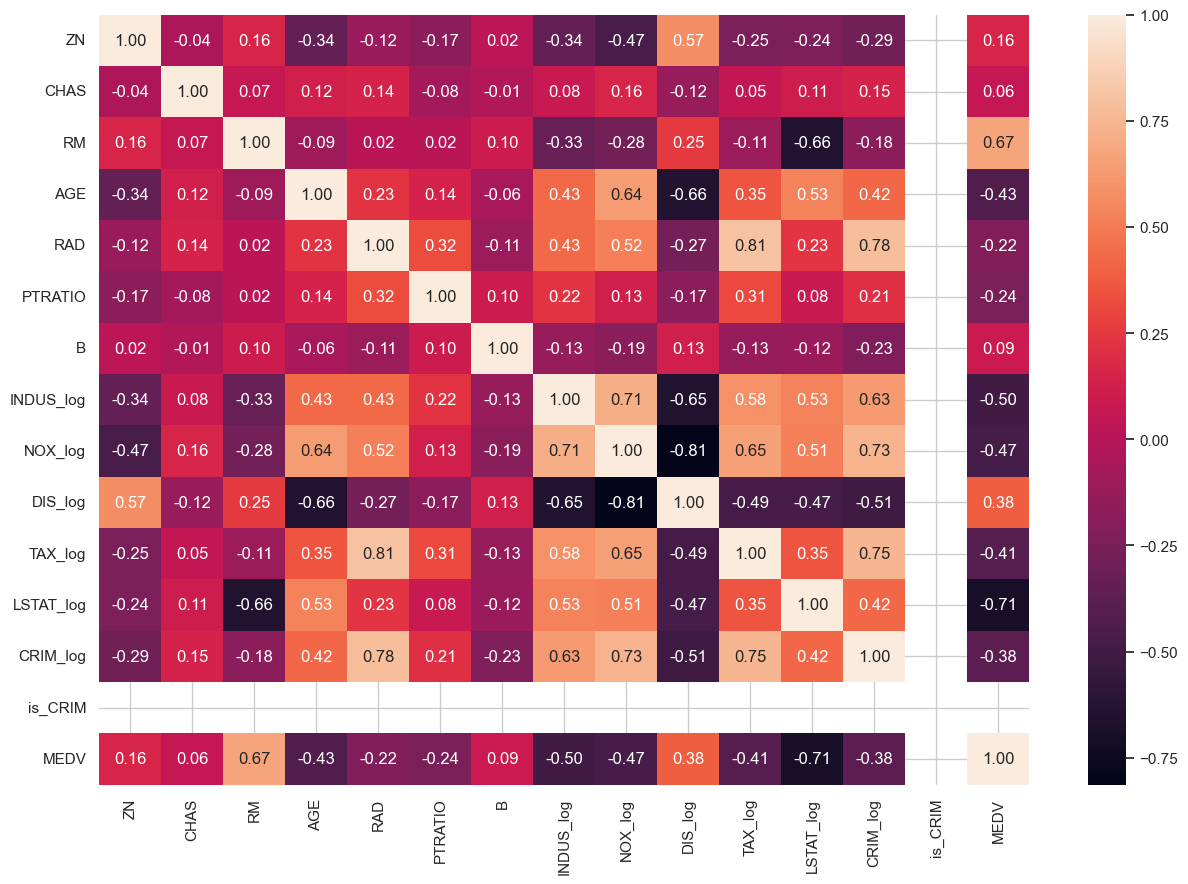

In [35]:
correlation_mtrx_preproc = data_for_corr_matrix.corr()
print_corr_matrix(correlation_mtrx_preproc)

In [38]:
selected_features = correlation_mtrx_preproc[abs(correlation_mtrx_preproc['MEDV']) > 0.6].index

# Вывод отобранных признаков
print(selected_features)

Index(['RM', 'LSTAT_log', 'MEDV'], dtype='object')


In [39]:
columns_to_fit = ['RM', 'LSTAT_log']
model_buf = LinearRegression()
model_buf.fit(X_train_preproc[columns_to_fit], y_train_preproc)

LinearRegression()

In [40]:
print_metrics(model_buf, X_test_preproc[columns_to_fit], y_test_preproc)

R2: 0.575072
MSE: 0.012235
MAE: 0.083103
